<a href="https://colab.research.google.com/github/SLKS99/-Physics-driven-discovery-and-optimization-of-hybrid-perovskite-films/blob/main/MAPbI3%2BGAPbBr3_sGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GP and sGP for exploration of bandgap Vs Concentration of $MAPbI_3$ + $GAPbBr_3$ mixed composition

August 2023
*   GP and sGP developed by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en) in [AtomAi](https://atomai.readthedocs.io/en/latest/)

*   Analysis performed by [Sheryl L. Sanchez](https://scholar.google.com/citations?hl=en&user=zFRKT-MAAAAJ)
*   Data by [Mahshid Ahmadi](https://scholar.google.com/citations?hl=en&user=DNOfTQ0AAAAJ&view_op=list_works&sortby=pubdate), Elham Foadian, [Sheryl L. Sanchez](https://scholar.google.com/citations?hl=en&user=zFRKT-MAAAAJ)
* workflow by [Sergei Kalinin](https://scholar.google.com/citations?user=-cuxoSQAAAAJ&hl=en)

In [1]:
#@title Import Modules

import os
import glob
import numpy as np
import pandas as pd

#Machine Learning Tools
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#Peak Finding
from scipy.stats import norm, multivariate_normal
import scipy.signal as ss

#Plotting Tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns
#gdown Installation
!pip install gdown==3.6.0

  Preparing metadata (setup.py) ... done
  Created wheel for gdown: filename=gdown-3.6.0-py3-none-any.whl size=5220 sha256=67a6a5809f8f2cf71c7b14ce0f3f18a7367b98ec21ed1a9cc9ce26335c98b210
  Stored in directory: /root/.cache/pip/wheels/a7/00/af/7528f0f7a7cd3f085b4b79d81e49744946b654fb19dd979363
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


## User Input

In [2]:
#plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.titleweight']='bold'

In [3]:
#@title Experimental Data

#Names of Precursors
precursor1 = '$MAPbI_3$' #@param {type:"string"}
precursor2 = '$GAPbBr_3$' #@param {type:"string"}

#Wells that we should ignore
wells_to_ignore = 'A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,B1,B3,B5,B7,B9,B11,B12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,D1,D3,D5,D7,D9,D11,D12,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,F1,F3,F5,F7,F9,F11,F12,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12' #@param {type:"string"}

#Information about Measurement Range
start_wavelength = 500 #@param {type:"integer"}
end_wavelength =  850 #@param {type:"integer"}
wavelength_step_size =   1#@param {type:"integer"}

time_step =  5#@param {type:"integer"}

#Information about the reads
number_of_reads = 1 #@param {type:"integer"}
luminescence_read_numbers = '1' #@param {type:"string"}

#Convert the string into a list to use later

if len(wells_to_ignore) !=0:
  wells_to_ignore = list(wells_to_ignore.split(","))
luminescence_read_numbers = list(luminescence_read_numbers.split(","))

In [4]:
#@title Data Information

#Name of files
data_file_name = 'all compositions.csv' #@param {type:'string'}
composition_file_name = '4-20-23 GAPbBr3 compositions.csv' #@param {type:'string'}

#Download the correct data
data_file = '13hREMYeu-uX3qQEj5YFpRpRs4k4-48NU' #@param {type:"string"}
composition_file = '16sc80Tc0hMhmb2S03MoqYBoJPbmGLUIz' #@param {type:"string"}

## Downloading and Formating Data

In [5]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file}

!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=13hREMYeu-uX3qQEj5YFpRpRs4k4-48NU
To: /content/all compositions.csv
100% 56.4k/56.4k [00:00<00:00, 64.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=16sc80Tc0hMhmb2S03MoqYBoJPbmGLUIz
To: /content/4-20-23 GAPbBr3 compositions.csv
100% 598/598 [00:00<00:00, 2.01MB/s]


In [6]:
#@title Into Pandas Dataframes
rawData = pd.read_csv(data_file_name, header=None)
rawData = rawData.replace('OVRFLW', np.NaN)

rawData = rawData.replace(r'^\s*$', np.nan, regex=True) #if blank add this
composition = pd.read_csv(composition_file_name, index_col = 0)


In [7]:
composition

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
GAPbBr3,NaN,NaN,NaN,NaN,90.0,NaN,NaN,27.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAPbI3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#@title Parsing the Data into a Dictionary
cells = []

for i in range(1, 9):
  for j in range(1 , 13):
    cells.append(chr(64 + i) + str(j))


for i in wells_to_ignore:
  composition = composition.drop(i, axis = 1)

#First the rows of measurements
rows = []

for i in range(1, number_of_reads + 1):

  rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':EM Spectrum'].index.tolist()

rows += rawData[rawData[rawData.columns[0]] == 'Results'].index.tolist()

#Separate into different dataframes

#First step, make a list of the names
names = []

for i in range(1, number_of_reads + 1):
  names.append('Read ' + str(i))

#Next, make a dictionary
d = {}

for c in names:
  split_name = c.split(' ')
  index = int(split_name[1])
  d[c] = rawData[rows[index - 1] + 2 :rows[index] - 1] #Take a section of the values
  d[c] = d[c].drop([0], axis = 1) #Drop the empty column
  d[c]=d[c].drop([1],axis=1)  # this is to drop the wavelength column only giving the composition values


  new_header = d[c].iloc[0] #grab the first row for the header
  d[c] = d[c][1:] #take the data less the header row
  d[c].columns = new_header #set the header row as the df header
  for i in wells_to_ignore:
    d[c] = d[c].drop(i, axis = 1)
  d[c] = d[c].astype(float) #Make sure that it is composed of numbers


In [14]:
#@title Convert the Dictionary into an Array
#Convert  into an array
luminescence_time = np.array(luminescence_read_numbers)
luminescence_time = [int(i) * time_step for i in luminescence_time]

#Convert wavelength information into an array
luminescence_wavelength = np.arange(start_wavelength,end_wavelength + wavelength_step_size,wavelength_step_size)

#Make a grid
nx, ny = np.meshgrid(luminescence_wavelength, luminescence_time)

#Load information into a dataframe
luminescence_df = pd.DataFrame()

for i in luminescence_read_numbers:

  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])

luminescence_df.insert(loc = 0, column = 'Time', value = ny.ravel())

luminescence_df = luminescence_df.fillna(0.0)



<ipython-input-14-b3550398771b>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])


In [37]:
luminescence= luminescence_df.drop(['Time'],axis=1)

In [38]:
scaler= MinMaxScaler()
arr_scaled = scaler.fit_transform(luminescence)
luminescence_norm = pd.DataFrame(arr_scaled, columns=luminescence.columns,index=luminescence.index)

print(luminescence_norm.describe())

luminescence=np.array(luminescence)

25             B2          B4          B6          B8         B10          D2  \
count  351.000000  351.000000  351.000000  351.000000  351.000000  351.000000   
mean     0.168388    0.165595    0.152899    0.148478    0.146109    0.144481   
std      0.291170    0.293971    0.284110    0.280273    0.278052    0.274278   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000132    0.000196    0.000213    0.000037    0.000053    0.000071   
50%      0.001126    0.001571    0.001704    0.002319    0.002578    0.003590   
75%      0.195346    0.169841    0.130990    0.118889    0.117780    0.117273   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

25             D4          D6          D8         D10          F2          F4  \
count  351.000000  351.000000  351.000000  351.000000  351.000000  351.000000   
mean     0.144111    0.149444    0.154283    0.140779    0.152871    0.178347   
std      0.273456    0.2783

In [39]:
df=d['Read 1']

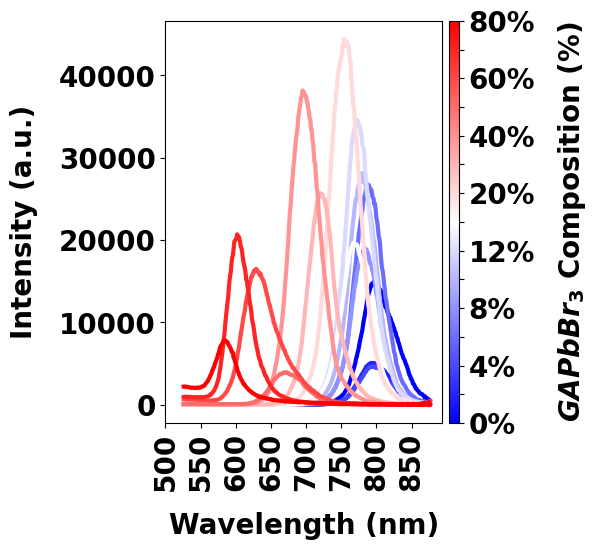

In [44]:




luminescence_wavelength = np.arange(start_wavelength, end_wavelength + wavelength_step_size, wavelength_step_size)

# Plot the normalized data
ax = d['Read 1'].plot(layout=(8, 13), figsize=(5, 5), cmap='bwr', linewidth=3, legend=False)
plt.tight_layout()
ax.set_xticks(np.arange(0, len(luminescence_wavelength), 50))
ax.set_xticklabels(luminescence_wavelength[0::50], rotation='vertical')

plt.xlabel('Wavelength (nm)', labelpad=15, size=20)
plt.ylabel('Intensity (a.u.)', labelpad=15, size=20)

# Create a ScalarMappable for colorbar
norm = mcolors.Normalize(vmin=0, vmax=1)  # Define the color normalization range
sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
sm.set_array([])  # Dummy array for colorbar

# Add colorbar for the percentage labels
composition_labels = ['0%', '', '4%', '', '8%', '', '12%', '', '20%', '', '40%', '', '60%', '', '80%']
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=40, ticks=np.linspace(0, 1, len(composition_labels)))
cbar.ax.set_ylabel('$GAPbBr_3$ Composition (%)', labelpad=15, size=20)
cbar.set_ticklabels(composition_labels)

plt.show()


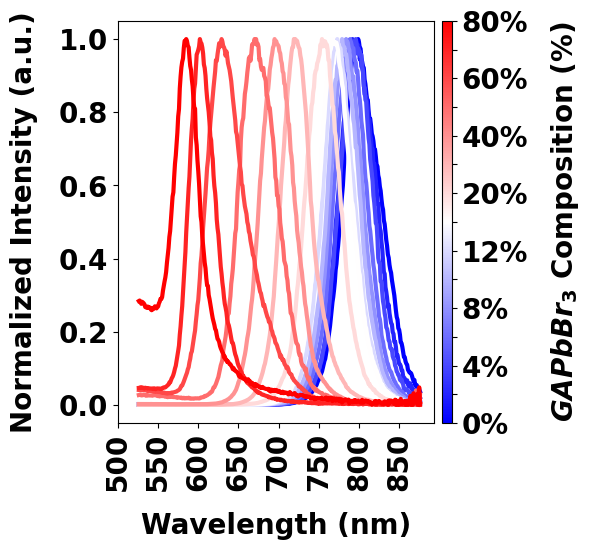

In [42]:



luminescence_wavelength = np.arange(start_wavelength, end_wavelength + wavelength_step_size, wavelength_step_size)

# Plot the normalized data
ax = luminescence_norm.plot(layout=(8, 13), figsize=(5, 5), cmap='bwr', linewidth=3, legend=False)
plt.tight_layout()
ax.set_xticks(np.arange(0, len(luminescence_wavelength), 50))
ax.set_xticklabels(luminescence_wavelength[0::50], rotation='vertical')

plt.xlabel('Wavelength (nm)', labelpad=15, size=20)
plt.ylabel('Normalized Intensity (a.u.)', labelpad=15, size=20)

# Create a ScalarMappable for colorbar
norm = mcolors.Normalize(vmin=0, vmax=1)  # Define the color normalization range
sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
sm.set_array([])  # Dummy array for colorbar

# Add colorbar for the percentage labels
composition_labels = ['0%', '', '4%', '', '8%', '', '12%', '', '20%', '', '40%', '', '60%', '', '80%']
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=40, ticks=np.linspace(0, 1, len(composition_labels)))
cbar.ax.set_ylabel('$GAPbBr_3$ Composition (%)', labelpad=15, size=20)
cbar.set_ticklabels(composition_labels)

plt.show()


In [45]:
compositions = composition.values.T
targets = d['Read 1'].values.T

luminescence_wavelength = np.arange(
    start_wavelength,end_wavelength + wavelength_step_size, wavelength_step_size)

print(compositions.shape, targets.shape, luminescence_wavelength.shape)

(15, 2) (15, 351) (351,)


<Axes: >

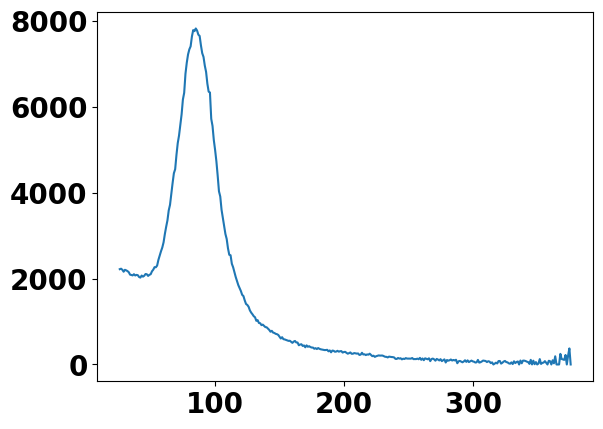

In [46]:
d['Read 1']['F10'].plot()

559 7816.0


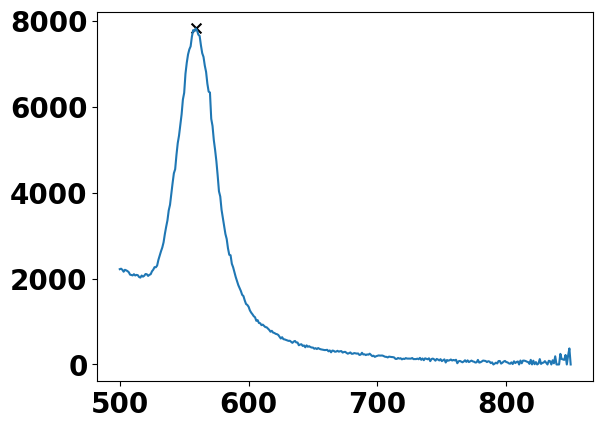

In [47]:


k = 14
# Plot the data
plt.plot(luminescence_wavelength, targets[k])

# Manually identify the peak location
peak_pos = np.argmax(targets[k])
peak_int = targets[k][peak_pos]

# Plot the peak
plt.scatter(luminescence_wavelength[peak_pos], peak_int, marker='x', s=50, c='k')

# Print the peak position and intensity
print(luminescence_wavelength[peak_pos], peak_int)


In [48]:
peaks_all, compositions_all = [], []

for i, t in enumerate(targets):
    # Manually identify the peak location
    peak_pos = np.argmax(t)
    peak_int = t[peak_pos]

    # Add the peak position and composition to the list
    peaks_all.append(peak_pos)
    compositions_all.append(compositions[i])

compositions_all = np.array(compositions_all)
peaks_all = np.array(peaks_all)
peaks_all = luminescence_wavelength[peaks_all]

print(compositions_all.shape, peaks_all.shape)


(15, 2) (15,)


In [49]:
compositions_all

array([[  0., 100.],
       [  2.,  98.],
       [  4.,  96.],
       [  6.,  94.],
       [  8.,  92.],
       [ 10.,  90.],
       [ 12.,  88.],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ 40.,  60.],
       [ 50.,  50.],
       [ 60.,  40.],
       [ 70.,  30.],
       [ 80.,  20.]])

Now for all peaks:

In [50]:
peaks_all, compositions_all = [], []

for i, t in enumerate(targets):
    # Manually identify the peak location
    peak_pos = np.argmax(t)
    peak_int = t[peak_pos]

    # Add the peak position and composition to the list
    peaks_all.append(peak_pos)
    compositions_all.append(compositions[i])

compositions_all = np.array(compositions_all)
peaks_all = np.array(peaks_all)
peaks_all = luminescence_wavelength[peaks_all]

print(compositions_all.shape, peaks_all.shape)


(15, 2) (15,)


In [51]:
bandgap=1240/peaks_all[:]
print(bandgap)

[1.60413972 1.61879896 1.61038961 1.62516383 1.63588391 1.64674635
 1.65997323 1.6734143  1.7032967  1.78932179 1.85351271 1.92546584
 2.05638474 2.15277778 2.21824687]


In [52]:
import seaborn

Text(0, 0.5, 'Peak Position (nm)')

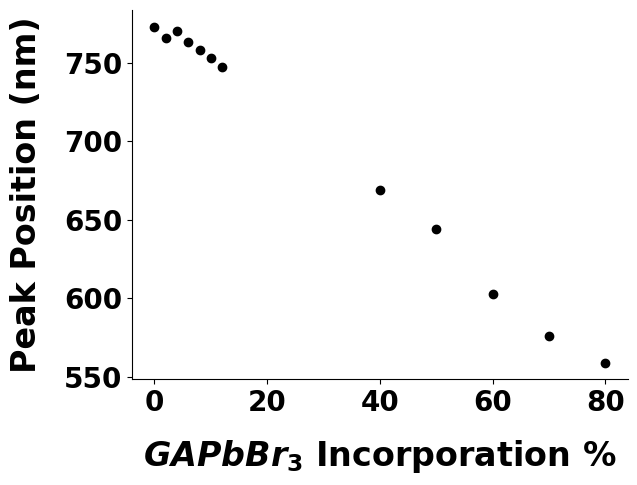

In [53]:
plt.scatter(compositions_all[:, 0], peaks_all, color='black')
sns.despine()
plt.xlabel('$GAPbBr_3$ Incorporation %', labelpad=15,size=24)
plt.ylabel('Peak Position (nm)', labelpad=15,size=24)

In [54]:
# Create a 2D array by horizontally stacking X and y
data = np.hstack((compositions_all[:,0].reshape(-1, 1), bandgap.reshape(-1, 1)))

# Save the data to a CSV file
np.savetxt('bandgap info.csv', data, delimiter=',', header='composition,bandgap', comments='')

In [55]:
data

array([[ 0.        ,  1.60413972],
       [ 2.        ,  1.61879896],
       [ 4.        ,  1.61038961],
       [ 6.        ,  1.62516383],
       [ 8.        ,  1.63588391],
       [10.        ,  1.64674635],
       [12.        ,  1.65997323],
       [        nan,  1.6734143 ],
       [        nan,  1.7032967 ],
       [        nan,  1.78932179],
       [40.        ,  1.85351271],
       [50.        ,  1.92546584],
       [60.        ,  2.05638474],
       [70.        ,  2.15277778],
       [80.        ,  2.21824687]])

Install GPax for running a fully Bayesian GP analysis:

In [56]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 11.3 MB/s eta 0:00:00


In [57]:
import gpax
import jax.random as jra
import jax.numpy as jnp
gpax.utils.enable_x64()

We start with vanilla GP model.

Before proceeding to training a GP model, we are going to define a custom prior on GP kernel parameters. This step is optional (if not specified, GPax will use default non-informative LogNormal(0, 1) priors), but can be helpful for better convergence:

In [58]:
import numpyro
import numpyro.distributions as dist

def kernel_prior():
    k_length = numpyro.sample("k_length", dist.Gamma(50,100))  # prior on kernel lengthscale
    k_scale = numpyro.sample("k_scale", dist.LogNormal(1, 3))  # prior on kernel output scale
    return {"k_length": k_length, "k_scale": k_scale}

In [59]:
noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.01))

In [60]:
# Read initial data
df_initial = pd.read_csv('bandgap info.csv')



In [61]:
df_initial.iloc[[0,14],[0,1]]

,composition,bandgap
0,0.0,1.604140
14,80.0,2.218247


## GP analysis

In [62]:
df_GP=pd.DataFrame(columns=['composition','bandgap'])
df_GP=pd.concat([df_initial.iloc[[0,14],[0,1]],
df_GP])



In [63]:
# input new data as dictionary
new_data_GP = {'composition': 80, 'bandgap': 2.21824687}

# append new data to dataframe
df_GP = df_GP.append(new_data_GP, ignore_index=True)


<ipython-input-63-694a6d449002>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_GP = df_GP.append(new_data_GP, ignore_index=True)


In [64]:
df_GP

,composition,bandgap
0,0.0,1.604140
1,80.0,2.218247
2,80.0,2.218247


In [65]:

X_GP= df_GP['composition'].values
y_GP=df_GP['bandgap'].values

sample: 100%|██████████| 4000/4000 [00:31<00:00, 126.56it/s, 1023 steps of size 4.77e-08. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.00      0.00      0.00      0.00      0.00      3.79      1.71
   k_scale      2.10      0.00      2.10      2.10      2.10      7.74      1.06
     noise      0.00      0.00      0.00      0.00      0.00      2.84      2.14



sample: 100%|██████████| 4000/4000 [00:16<00:00, 245.27it/s, 1023 steps of size 4.77e-08. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.00      0.00      0.00      0.00      0.00      3.79      1.71
   k_scale      2.10      0.00      2.10      2.10      2.10      7.74      1.06
     noise      0.00      0.00      0.00      0.00      0.00      2.84      2.14



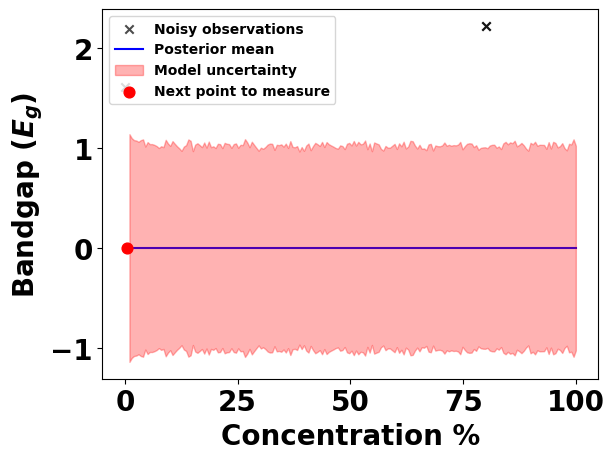

Next point: [0.50251256]


In [ ]:

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior=kernel_prior, noise_prior=noise_prior)
# Run MCMC to obtain posterior samples for the GP model parameters
gp_model.fit(rng_key, X_GP, y_GP, num_chains=1)

# Generate denser grid for prediction
X_new = jnp.linspace(0, 100, 200)[:, None]
X_new = jnp.delete(X_new, np.where(X_new == X_GP)[0], axis=0)

# Update GP model
gp_model.fit(rng_key, X_GP, y_GP, num_chains=1)

# Get next point
y_mean, y_samples = gp_model.predict_in_batches(rng_key_predict, X_new, noiseless=True)
U = y_samples.mean(1).var(0).squeeze()
next_point = U.argmax()
X_next = X_new[next_point]
# Update X_new
X_new = jnp.delete(X_new, next_point, axis=0)

# Re-predict mean and samples
y_mean, y_samples = gp_model.predict_in_batches(rng_key_predict, X_new, noiseless=True)

 # Plot results
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("Concentration %")
ax.set_ylabel("Bandgap ($E_g$)")
ax.scatter(X_GP, y_GP, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
ax.plot(X_new, y_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.fill_between(X_new.squeeze(), y_mean - y_samples.std(axis=(0,1)), y_mean + y_samples.std(axis=(0,1)),
                    color='r', alpha=0.3, label="Model uncertainty")
ax.scatter(X_next, y_mean[next_point], s=60, c='r', label='Next point to measure')
ax.legend(loc='upper left', fontsize=10)
plt.show()
print(f"Next point: {X_next}")




Initialize and train a single GP model using composition as an input and peak location as an output:

Now predict the next concentration:

Now we do structured GP (sGP) where our "physical model" is 1) simple a linear function, 2) a piecewise linear function, 3) a quadratic function

define deteministic mean functions and probabisitic priors over their parameters:

##sGP

In [66]:
df_initial.iloc[[0,14],[0,1]]


,composition,bandgap
0,0.0,1.604140
14,80.0,2.218247


In [67]:
import numpyro
from typing import Dict

# Linear function
def linear(x, params):
    """Linear mean function"""
    return params["a"] * x + params["b"]

# Priors over the linear function
def linear_prior():
    """Priors over linear coefficients"""
    a = numpyro.sample("a", numpyro.distributions.LogNormal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.Uniform(1, 3))
    return {"a": a, "b": b}

# Piecewise linear function
def piecewise(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    """Piecewise linear function"""
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: params["a1"] * x + params["b1"],
         lambda x: params["a2"] * x + params["b2"]])

# Priors over the picewise function
def piecewise_prior():
    """Priors over coefficients"""
    a1 = numpyro.sample("a1", numpyro.distributions.LogNormal(0, 1))
    b1 = numpyro.sample("b1", numpyro.distributions.Normal(1, 3))
    a2 = numpyro.sample("a2", numpyro.distributions.LogNormal(0, 1))
    b2 = numpyro.sample("b2", numpyro.distributions.Normal(1, 3))
    t = numpyro.sample("t", numpyro.distributions.Uniform(10, 100))
    return {"a1": a1, "b1": b1, "a2": a2, "b2": b2, "t": t}

# Quadratic function
def quadratic(x, params):
    """Quadratic function"""
    return params["a"] * x**2 + params["b"] * x + params["c"]

# Priors over the quadratic function
def quadratic_prior():
    """Priors over coefficients"""
    a = numpyro.sample("a", numpyro.distributions.LogNormal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.Normal(1, 3))
    c = numpyro.sample("c", numpyro.distributions.Normal(1, 3))
    return {"a": a, "b": b, "c": c}

In [68]:
noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.01))

**bold text**

Run sGP with linear mean function:

## Linear mean function

### Run once initially!

In [ ]:
all_uncertainty_linear = []


In [ ]:
df_linear=pd.DataFrame(columns=['composition','bandgap'])
df_linear=pd.concat([df_initial.iloc[[0,14],[0,1]],
df_linear])


###Only run new data if adding in new data!

In [ ]:
# input new data as dictionary
new_data = {'composition': 43, 'bandgap':1.86186186186}

# append new data to dataframe
df_linear = df_linear.append(new_data, ignore_index=True)


<ipython-input-316-fefbc80ae6b4>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_linear = df_linear.append(new_data, ignore_index=True)


In [ ]:


# convert dataframe to numpy array
X_linear = df_linear['composition'].values
y_linear = df_linear['bandgap'].values

# print updated numpy arrays
print(X_linear)
print(y_linear)




[ 0.  80.  98.  88.  70.  30.  92.  10.  50.  14.  60.  40.  20.   0.5
 83.  43. ]
[1.60413972 2.21824687 2.33521657 2.26277372 2.15277778 1.78932179
 2.2962963  1.64674635 1.92546584 1.6734143  2.05638474 1.85351271
 1.7032967  1.60413972 2.21033868 1.86186186]


In [ ]:

# Get random number generator keys
rng_key, rng_key_predict = gpax.utils.get_keys()
# initialize structured GP model
sgp_model = gpax.ExactGP(1, kernel='Matern',
                         mean_fn=linear, mean_fn_prior=linear_prior, kernel_prior=None,noise_prior=noise_prior)
# Run MCMC to obtain posterior samples
sgp_model.fit(rng_key, X_linear, y_linear, jitter=1e-4)

# Generate denser grid for prediction
X_new = jnp.linspace(0, 98, 200)[:, None]
X_new = jnp.delete(X_new, np.where(X_new==X_linear)[0], axis=0)
# Make a prediction
y_mean, y_samples = sgp_model.predict_in_batches(rng_key_predict, X_new, noiseless=True, jitter=1e-4)


sample: 100%|██████████| 4000/4000 [00:09<00:00, 412.99it/s, 15 steps of size 3.41e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.01      0.01      0.01      0.01      0.02   1061.21      1.00
          b      1.55      0.39      1.48      1.00      2.07   1444.20      1.00
k_length[0]     79.83     31.15     74.43     33.63    124.42    734.89      1.00
    k_scale      0.54      0.66      0.32      0.02      1.26    973.32      1.00
      noise      0.00      0.00      0.00      0.00      0.00   1723.16      1.00



In [ ]:
# Compute uncertainty
obj = gpax.acquisition.UE(
        rng_key_predict, sgp_model, X_new, noiseless=False, jitter=1e-4)
next_point = obj.argmax()
X_next1 = X_new[next_point]


print(X_next1)

[64.51256281]


[64.51256281]


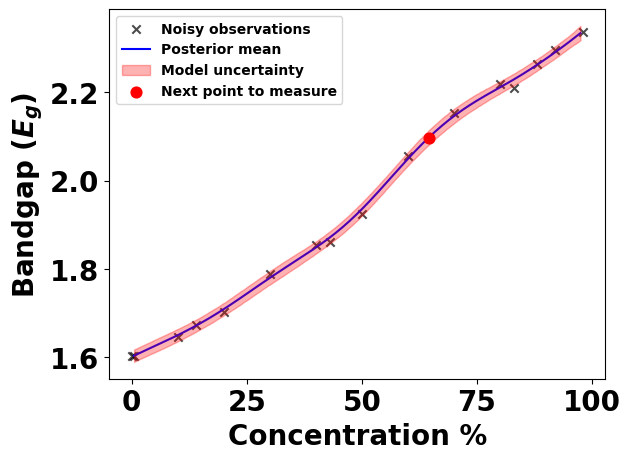

In [ ]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("Concentration %")
ax.set_ylabel("Bandgap ($E_g$)")
ax.scatter(X_linear, y_linear, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
ax.plot(X_new, y_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.fill_between(X_new.squeeze(), y_mean - y_samples.std(axis=(0,1)), y_mean + y_samples.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")

ax.scatter(X_next1, y_mean[next_point], s=60, c='r', label='Next point to measure')

ax.legend(loc='upper left',fontsize=10)

print(X_next1)




In [ ]:
# add the uncertainty of this step to the list
this_uncertainty = y_samples.std(axis=(0,1)).sum()
all_uncertainty_linear.append(this_uncertainty)


In [ ]:
all_uncertainty_linear

[Array(385.38153668, dtype=float64),
 Array(260.0538491, dtype=float64),
 Array(182.78069284, dtype=float64),
 Array(129.65653964, dtype=float64),
 Array(104.74826199, dtype=float64),
 Array(65.97706284, dtype=float64),
 Array(36.21214906, dtype=float64),
 Array(17.11564955, dtype=float64),
 Array(5.24538859, dtype=float64),
 Array(4.10923965, dtype=float64),
 Array(3.35586251, dtype=float64),
 Array(3.05067168, dtype=float64),
 Array(2.87369752, dtype=float64),
 Array(2.97067812, dtype=float64),
 Array(2.86357389, dtype=float64)]

## With piecewise mean function:

Only run the below code once!

In [69]:
all_uncertainty_piecewise3 = []

In [90]:
df_piecewise=pd.DataFrame(columns=['composition','bandgap'])

df_piecewise=pd.concat ([df_initial.iloc[[0,14],[0,1]],df_piecewise])




###Only run this if adding new compositions!!

In [97]:
import pandas as pd

# Existing DataFrame or create an empty one
data = {'composition': [0.0, 80.0],
        'bandgap': [1.60414, 2.218247]}
df_piecewise = pd.DataFrame(data)

# New data to append
new_data_p = {'composition': [43, 98, 30, 20, 14, 10, 92, 60, 70, 36,97,83,4,50],
              'bandgap': [1.86186186, 2.33521657, 1.78932179, 1.7032967, 1.6734143,
                          1.64674635, 2.2962963, 2.05638474, 2.15277778, 1.8128655,2.33962264, 2.21033868, 1.61038961, 1.92546584]}

# Append new data to the DataFrame
df_piecewise = df_piecewise.append(pd.DataFrame(new_data_p), ignore_index=True)

print(df_piecewise)


    composition   bandgap
0           0.0  1.604140
1          80.0  2.218247
2          43.0  1.861862
3          98.0  2.335217
4          30.0  1.789322
5          20.0  1.703297
6          14.0  1.673414
7          10.0  1.646746
8          92.0  2.296296
9          60.0  2.056385
10         70.0  2.152778
11         36.0  1.812866
12         97.0  2.339623
13         83.0  2.210339
14          4.0  1.610390
15         50.0  1.925466


<ipython-input-97-09c5bdf381ec>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_piecewise = df_piecewise.append(pd.DataFrame(new_data_p), ignore_index=True)


In [98]:
# convert dataframe to numpy array
X_piecewise = df_piecewise['composition'].values
y_piecewise = df_piecewise['bandgap'].values


# print updated numpy arrays
print(X_piecewise)
print(y_piecewise)


[ 0. 80. 43. 98. 30. 20. 14. 10. 92. 60. 70. 36. 97. 83.  4. 50.]
[1.60414    2.218247   1.86186186 2.33521657 1.78932179 1.7032967
 1.6734143  1.64674635 2.2962963  2.05638474 2.15277778 1.8128655
 2.33962264 2.21033868 1.61038961 1.92546584]


In [99]:
# Get random number generator keys
rng_key, rng_key_predict = gpax.utils.get_keys()
# initialize structured GP model
sgp_model = gpax.ExactGP(1, kernel='Matern',
                         mean_fn=piecewise, mean_fn_prior=piecewise_prior)
# Run MCMC to obtain posterior samples
sgp_model.fit(rng_key, X_piecewise,y_piecewise,jitter=1e-4)

# Generate denser grid for prediction
X_new = jnp.linspace(0, 98, 200)[:, None]
X_new = jnp.delete(X_new, np.where(X_new==X_piecewise)[0], axis=0)
# Make a prediction
y_mean, y_samples = sgp_model.predict_in_batches(rng_key_predict, X_new, noiseless=True)

sample: 100%|██████████| 4000/4000 [00:12<00:00, 311.66it/s, 11 steps of size 2.23e-01. acc. prob=0.71]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1      0.02      0.01      0.02      0.01      0.03     96.09      1.01
         a2      1.47      1.77      0.97      0.05      3.17    430.28      1.00
         b1      1.20      0.63      1.28      0.27      2.18    157.87      1.01
         b2      0.90      3.08      1.08     -4.26      5.75    322.61      1.00
k_length[0]     62.51     41.50     54.98      1.42    123.41     89.37      1.01
    k_scale      0.56      0.79      0.33      0.01      1.21    186.48      1.00
      noise      0.01      0.02      0.01      0.00      0.03    148.12      1.01
          t     98.95      0.56     98.93     98.03     99.76    186.67      1.01



In [ ]:

# Compute uncertainty
obj = gpax.acquisition.UE(
        rng_key_predict, sgp_model, X_new, noiseless=False, jitter=1e-4)
next_point = obj.argmax()
X_next2 = X_new[next_point]


print(X_next2)

[66.97487437]


NameError: ignored

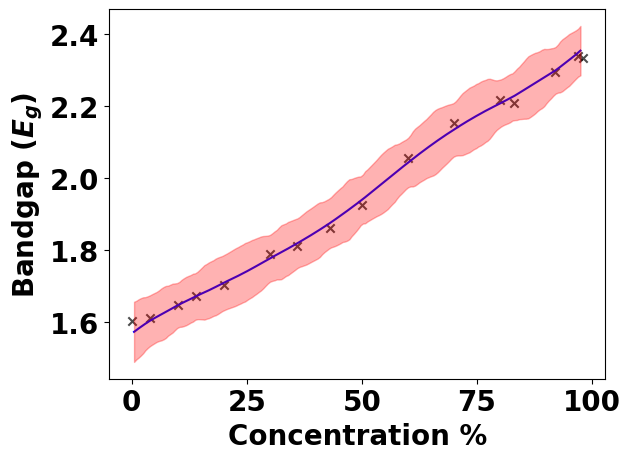

In [101]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("Concentration %")
ax.set_ylabel("Bandgap ($E_g$)")
ax.scatter(X_piecewise, y_piecewise, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
ax.plot(X_new, y_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.fill_between(X_new.squeeze(), y_mean - y_samples.std(axis=(0,1)), y_mean + y_samples.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")

ax.scatter(X_next2, y_mean[next_point], s=60, c='r', label='Next point to measure')
#ax.legend(loc='upper left',fontsize=10)


print(X_next2)

In [ ]:
 # add the uncertainty of this step to the list
this_uncertainty_p = y_samples.std(axis=(0,1)).sum()
all_uncertainty_piecewise3.append(this_uncertainty_p)

In [ ]:
all_uncertainty_piecewise3

[Array(9202.04703908, dtype=float64),
 Array(4300.48539711, dtype=float64),
 Array(2233.4312136, dtype=float64),
 Array(1521.98651457, dtype=float64),
 Array(770.1010928, dtype=float64),
 Array(374.39148273, dtype=float64),
 Array(147.40294225, dtype=float64),
 Array(201.00903806, dtype=float64),
 Array(170.27029573, dtype=float64),
 Array(117.93761953, dtype=float64),
 Array(71.19464219, dtype=float64),
 Array(56.90241424, dtype=float64),
 Array(37.91749565, dtype=float64),
 Array(21.31087978, dtype=float64),
 Array(13.15794572, dtype=float64)]

### Piecewise for automatic choosing of bandgap for iteration purposes

## Quadratic mean function

In [ ]:
all_uncertainty_quad = []

In [ ]:
df_quadratic=pd.DataFrame(columns=['composition','bandgap'])

df_quadratic=pd.concat ([df_initial.iloc[[0,14],[0,1]],df_quadratic])


In [ ]:
# input new data as dictionary
new_data_q = {'composition': 70, 'bandgap': 2.15277778}

# append new data to dataframe
df_quadratic = df_quadratic.append(new_data_q, ignore_index=True)


<ipython-input-293-9e77f52166d4>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_quadratic = df_quadratic.append(new_data_q, ignore_index=True)


In [ ]:



# convert dataframe to numpy array
X_quadratic = df_quadratic['composition'].values
y_quadratic = df_quadratic['bandgap'].values

# print updated numpy arrays
print(X_quadratic)
print(y_quadratic)




[ 0. 80. 98. 40. 48. 95. 25. 60.  6. 50. 48. 14. 70.]
[1.60413972 2.21824687 2.33521657 1.85351271 1.96202532 2.32645403
 1.69398907 2.05638474 1.62516383 1.92546584 1.96202532 1.6734143
 2.15277778]


In [ ]:

# Get random number generator keys
rng_key, rng_key_predict = gpax.utils.get_keys()
# initialize structured GP model
sgp_model = gpax.ExactGP(1, kernel='Matern',
                         mean_fn=quadratic, mean_fn_prior=quadratic_prior)
# Run MCMC to obtain posterior samples
sgp_model.fit(rng_key, X_quadratic, y_quadratic,jitter=1e-4)
# Generate denser grid for prediction
X_new = jnp.linspace(0, 98, 200)[:, None]
X_new = jnp.delete(X_new, np.where(X_new==X_quadratic)[0], axis=0)
# Make a prediction
y_mean, y_samples = sgp_model.predict_in_batches(rng_key_predict, X_new, noiseless=True)


sample: 100%|██████████| 4000/4000 [00:12<00:00, 326.68it/s, 31 steps of size 1.14e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.00      0.00      0.00      0.00      0.00    343.20      1.01
          b     -0.10      0.05     -0.09     -0.19     -0.03    334.32      1.01
          c      2.30      1.39      2.40      0.05      4.63    703.41      1.00
k_length[0]     23.52     15.97     22.50      0.06     45.43    286.61      1.00
    k_scale      2.14      2.48      1.39      0.12      4.79    518.22      1.00
      noise      0.17      0.25      0.09      0.00      0.40    370.86      1.00



In [ ]:

# Compute uncertainty
obj = gpax.acquisition.UE(
        rng_key_predict, sgp_model, X_new, noiseless=False, jitter=1e-4)
next_point = obj.argmax()
X_next3 = X_new[next_point]


print(X_next3)

[88.15075377]


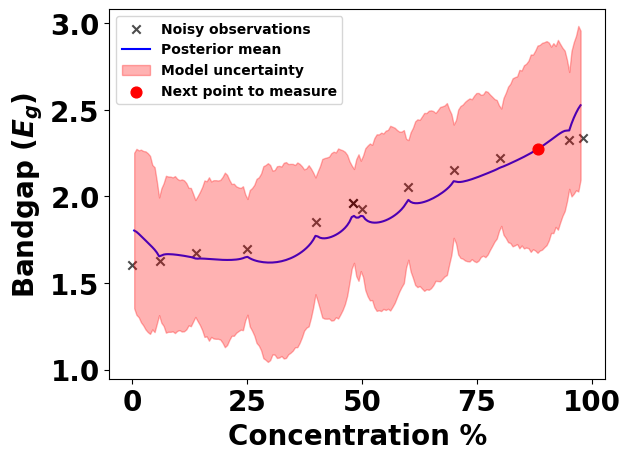

In [ ]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("Concentration %")
ax.set_ylabel("Bandgap ($E_g$)")
ax.scatter(X_quadratic, y_quadratic, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
ax.plot(X_new, y_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.fill_between(X_new.squeeze(), y_mean - y_samples.std(axis=(0,1)), y_mean + y_samples.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")

ax.scatter(X_next3, y_mean[next_point], s=60, c='r', label='Next point to measure')
ax.legend(loc='upper left',fontsize=10)


In [ ]:

 # add the uncertainty of this step to the list
this_uncertainty_q = y_samples.std(axis=(0,1)).sum()
all_uncertainty_quad.append(this_uncertainty_q)

In [ ]:
all_uncertainty_quad

[Array(4574.26240337, dtype=float64),
 Array(983.96520294, dtype=float64),
 Array(581.04654752, dtype=float64),
 Array(476.74128792, dtype=float64),
 Array(396.16618305, dtype=float64),
 Array(324.90352038, dtype=float64),
 Array(282.80710564, dtype=float64),
 Array(240.81182081, dtype=float64),
 Array(196.94873464, dtype=float64),
 Array(163.1031117, dtype=float64),
 Array(118.20206619, dtype=float64),
 Array(91.81745509, dtype=float64)]

## plot all uncertainty

In [ ]:
Uncertainity_sGP= pd.DataFrame(list(zip(all_uncertainty_linear,all_uncertainty_piecewise3)),columns=['Linear','Piecewise'])
#Uncertainity_sGP= pd.DataFrame(list(zip(all_uncertainty_linear)),columns=['Linear'])
#Uncertainity_sGP= pd.DataFrame(list(zip(all_uncertainty_linear,all_uncertainty_quad,all_uncertainty_piecewise3)),columns=['Linear','Quadratic','Piecewise'])
sgp_uncertainity=np.array(
Uncertainity_sGP)

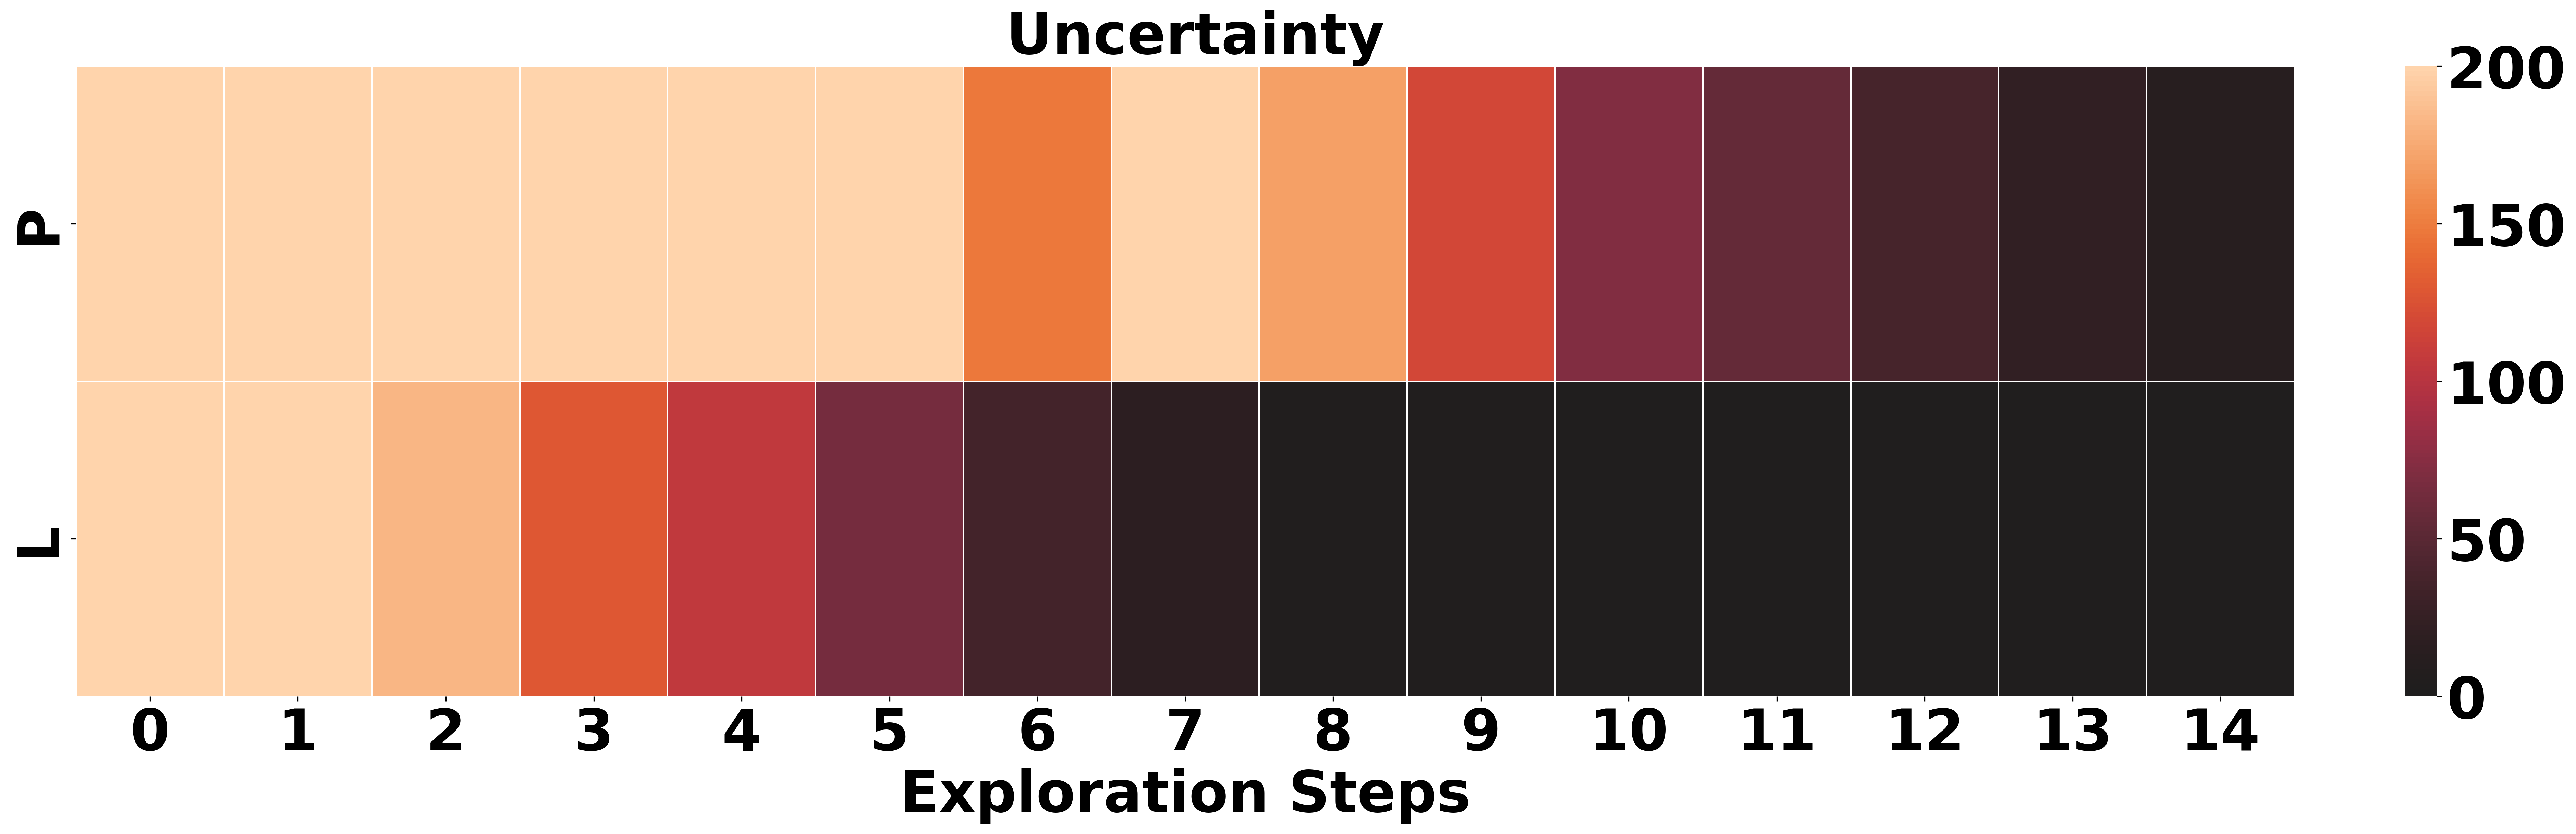

In [ ]:

fig, ax = plt.subplots(figsize=(25,8),dpi=300,constrained_layout=True)

ax = sns.heatmap(Uncertainity_sGP.astype(float).T,vmin=0,vmax= 200,ax=ax,annot=False,annot_kws={'fontsize':30,'rotation':90},linewidth=0.5,center=0.5, fmt='.1f')
ax.invert_yaxis()

ax.yaxis.set_ticklabels(['L','P'],fontsize=40)
ax.set_xlabel('Exploration Steps',fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_title (' Uncertainty',fontsize=40)
cbar = ax.collections[0].colorbar

cbar.ax.tick_params(labelsize=40)


In [ ]:
Uncertainity_sGP

,Linear,Quadratic,Piecewise
0,385.3815366842553,4574.262403367004,9202.047039077837
1,260.0538490955306,983.9652029373412,4300.4853971093335
2,182.7806928396672,581.0465475247757,2233.43121360017
3,129.65653963734223,476.74128792380134,1521.9865145733866
4,104.7482619943112,396.166183051683,770.1010928000794
5,65.97706284142312,324.9035203771075,374.39148272556764


In [ ]:
import seaborn as sns